In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn
import scipy
import pandas as pd
import matplotlib.pyplot as plt



In [3]:

from src.utils.utils import lp_error
from src.utils.logger import Logging
from src.utils.colors import model_color
from src.utils.draw_contour_plts import (
    plot_time_profile_regular_data_IBM_uvp,
    draw_contour_plts,
    draw_interface_contour_plts
)
from src.nn.tanh import MLP
from src.nn.bspline import KAN
from src.utils.utils import clear_gpu_memory
from src.data.IBM_data_loader import prepare_training_data, visualize_tensor_datasets
from src.data.IBM_data_loader import load_training_dataset, load_fluid_testing_dataset
from src.models.m2 import PINNTrainer
from src.utils.plot_losses import plot_M1_loss_history
from src.utils.fsi_visualization import create_frames , create_animations_from_existing_frames


In [4]:

CHECKPOINT_PATH =  "./checkpoints"
logger = Logging(CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(model_dirname)


INFO:src.utils.logger:./checkpoints/2025-04-30_11-21-30-658507


In [5]:

clear_gpu_memory()
config = {
    # Data parameters
    'dataset_type': 'new',
    'training_selection_method': 'Sobol',
    # Model parameters
    'input_dim': 3,      # (x, y, z, t)
    'hidden_dim': 100,
    'hidden_layers_dim': 3,
    
    # Physics parameters
    'fluid_density': 1.0,
    'fluid_viscosity': 0.01,
    
    # Training parameters
    'num_epochs': 10000,
    'batch_size': 265,
    'learning_rate': 1e-3,
    # Loss weights
    'data_weight': 4.0,
    'physics_weight': 1.0,
    'boundary_weight': 4.0,
    'fsi_weight': 1.0,
    'initial_weight': 4.0,
    
    # Checkpoint parameters
    'checkpoint_dir': './checkpoints',
    'resume': None,
    'print_every': 100,
    'save_every': 500,
    
    # Data sampling parameters
    'fluid_sampling_ratio': 0.005,
    'interface_sampling_ratio': 0.02,
    'solid_sampling_ratio': 0.05,
    'left_sampling_ratio': 0.1,
    'right_sampling_ratio': 0.15,
    'bottom_sampling_ratio': 0.1,
    'top_sampling_ratio': 0.1,
    'initial_sampling_ratio': 0.1,
    
    # Device parameters
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'solver': 'mlp',
    'model': 'm2'
}


GPU memory cleared!


In [6]:

## print the config
logger.print("Config:")
for key, value in config.items():
    logger.print(f"{key}: {value}")



INFO:src.utils.logger:Config:
INFO:src.utils.logger:dataset_type: new
INFO:src.utils.logger:training_selection_method: Sobol
INFO:src.utils.logger:input_dim: 3
INFO:src.utils.logger:hidden_dim: 100
INFO:src.utils.logger:hidden_layers_dim: 3
INFO:src.utils.logger:fluid_density: 1.0
INFO:src.utils.logger:fluid_viscosity: 0.01
INFO:src.utils.logger:num_epochs: 10000
INFO:src.utils.logger:batch_size: 265
INFO:src.utils.logger:learning_rate: 0.001
INFO:src.utils.logger:data_weight: 4.0
INFO:src.utils.logger:physics_weight: 1.0
INFO:src.utils.logger:boundary_weight: 4.0
INFO:src.utils.logger:fsi_weight: 1.0
INFO:src.utils.logger:initial_weight: 4.0
INFO:src.utils.logger:checkpoint_dir: ./checkpoints
INFO:src.utils.logger:resume: None
INFO:src.utils.logger:print_every: 100
INFO:src.utils.logger:save_every: 500
INFO:src.utils.logger:fluid_sampling_ratio: 0.005
INFO:src.utils.logger:interface_sampling_ratio: 0.02
INFO:src.utils.logger:solid_sampling_ratio: 0.05
INFO:src.utils.logger:left_sampli

In [7]:
training_data_path = './data/training_dataset/new'

# Load data

training_data = load_training_dataset(training_data_path  , device=config['device'])
# print(f"Training data type: {training_data[list(training_data.keys())[0]].dtype}")

if training_data is None:
    training_data = prepare_training_data(dataset_type=config['dataset_type'], 
                                                  fluid_sampling_ratio=config['fluid_sampling_ratio'],
                                                  interface_sampling_ratio=config['interface_sampling_ratio'],
                                                  solid_sampling_ratio=config['solid_sampling_ratio'],
                                                  left_sampling_ratio=config['left_sampling_ratio'],
                                                  right_sampling_ratio=config['right_sampling_ratio'],
                                                  bottom_sampling_ratio=config['bottom_sampling_ratio'],
                                                  top_sampling_ratio=config['top_sampling_ratio'],
                                                  initial_sampling_ratio=config['initial_sampling_ratio'],
                                                  training_selection_method=config['training_selection_method'],
                                                  device=config['device'],
                                                  save_dir=training_data_path)


visualize_tensor_datasets(training_data, save_dir=training_data_path)



Loaded interface tensor from ./data/training_dataset/new/interface_tensor.pt with shape torch.Size([2040, 8])
Loaded fluid tensor from ./data/training_dataset/new/fluid_tensor.pt with shape torch.Size([5329, 8])
Loaded left tensor from ./data/training_dataset/new/left_tensor.pt with shape torch.Size([1020, 8])
Loaded initial tensor from ./data/training_dataset/new/initial_tensor.pt with shape torch.Size([1116, 8])
Loaded bottom tensor from ./data/training_dataset/new/bottom_tensor.pt with shape torch.Size([1020, 8])
Loaded right tensor from ./data/training_dataset/new/right_tensor.pt with shape torch.Size([1530, 8])
Loaded fluid_points tensor from ./data/training_dataset/new/fluid_points_tensor.pt with shape torch.Size([1818, 8])
Loaded solid tensor from ./data/training_dataset/new/solid_tensor.pt with shape torch.Size([254, 8])
Loaded up tensor from ./data/training_dataset/new/up_tensor.pt with shape torch.Size([1020, 8])
Loaded training dataset from ./data/training_dataset/new succes

In [8]:
fluid_network = [config['input_dim']] + [config['hidden_dim']] * config['hidden_layers_dim'] + [3]
solid_network = [config['input_dim']] + [config['hidden_dim']] * config['hidden_layers_dim'] + [3]

if config['solver'] == 'mlp':
    fluid_model = MLP(network=fluid_network)
    solid_model = MLP(network=solid_network)
else:
    fluid_model = KAN(network=fluid_network)
    solid_model = KAN(network=solid_network)

logger.print(f"Fluid model architecture:")
logger.print(fluid_model)
logger.print(f"Number of parameters: {sum(p.numel() for p in fluid_model.parameters())}")

logger.print(f"Solid model architecture:")
logger.print(solid_model)
logger.print(f"Number of parameters: {sum(p.numel() for p in solid_model.parameters())}")


INFO:src.utils.logger:Fluid model architecture:
INFO:src.utils.logger:MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=3, bias=True)
  )
)
INFO:src.utils.logger:Number of parameters: 20903
INFO:src.utils.logger:Solid model architecture:
INFO:src.utils.logger:MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=3, bias=True)
  )
)
INFO:src.utils.logger:Number of parameters: 20903


In [9]:

# Create trainer
trainer = PINNTrainer(
    fluid_model=fluid_model,
    solid_model=solid_model,
    training_data=training_data,
    learning_rate=config['learning_rate'],
    logger=logger,
    device=config['device'],
    fluid_density=config['fluid_density'],
    fluid_viscosity=config['fluid_viscosity'],
    print_every=config['print_every'],
    save_every=config['save_every'],
    solver=config['solver'],
    model=config['model']
)


# Train model
loss_history = trainer.train(
    num_epochs=config['num_epochs'],
    batch_size=config['batch_size'],
    data_weight=config['data_weight'],
    physics_weight=config['physics_weight'],
    boundary_weight=config['boundary_weight'],
    fsi_weight=config['fsi_weight'],
    initial_weight=config['initial_weight'])



/home/vlq26735/anaconda3/envs/pinn_ibm4fsi/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:src.utils.logger:Epoch 100/10000, Total: 2.2e+00, Physics: 5.8e-03, Boundary: 1.6e+00, FSI: 4.6e-01, Initial: 1.6e-01, LR: 1.00e-03
INFO:src.utils.logger:Epoch 200/10000, Total: 2.0e+00, Physics: 2.3e-02, Boundary: 1.4e+00, FSI: 4.6e-01, Initial: 1.5e-01, LR: 1.00e-03
INFO:src.utils.logger:Epoch 300/10000, Total: 9.5e-01, Physics: 2.5e-02, Boundary: 5.8e-01, FSI: 2.1e-01, Initial: 1.2e-01, LR: 1.00e-03
INFO:src.utils.logger:Epoch 400/10000, Total: 8.1e-01, Physics: 3.0e-02, Boundary: 4.7e-01, FSI: 1.9e-01, Initial: 1.1e-01, LR: 1.00e-03
INFO:src.utils.logger:Epoch 500/10000, Total: 6.9e-01, Physics: 2.8e-02, Boundary: 3.9e-01, FSI: 1.7e-01, Initial: 1.0e-01, LR: 1.00e-03
INFO:src.utils.logger:Fina

KeyboardInterrupt: 

INFO:src.utils.logger:Number of parameters: 20903
/home/vlq26735/saiful/afrah/code/pinn_ibm4fsi2/src/utils/plot_losses.py:141: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=y_min)


final loss BC: 2.15e-01
final loss Physics: 2.64e-02
final loss FSI: 1.21e-01
final loss Initial: 5.63e-02
final loss Total: 4.19e-01


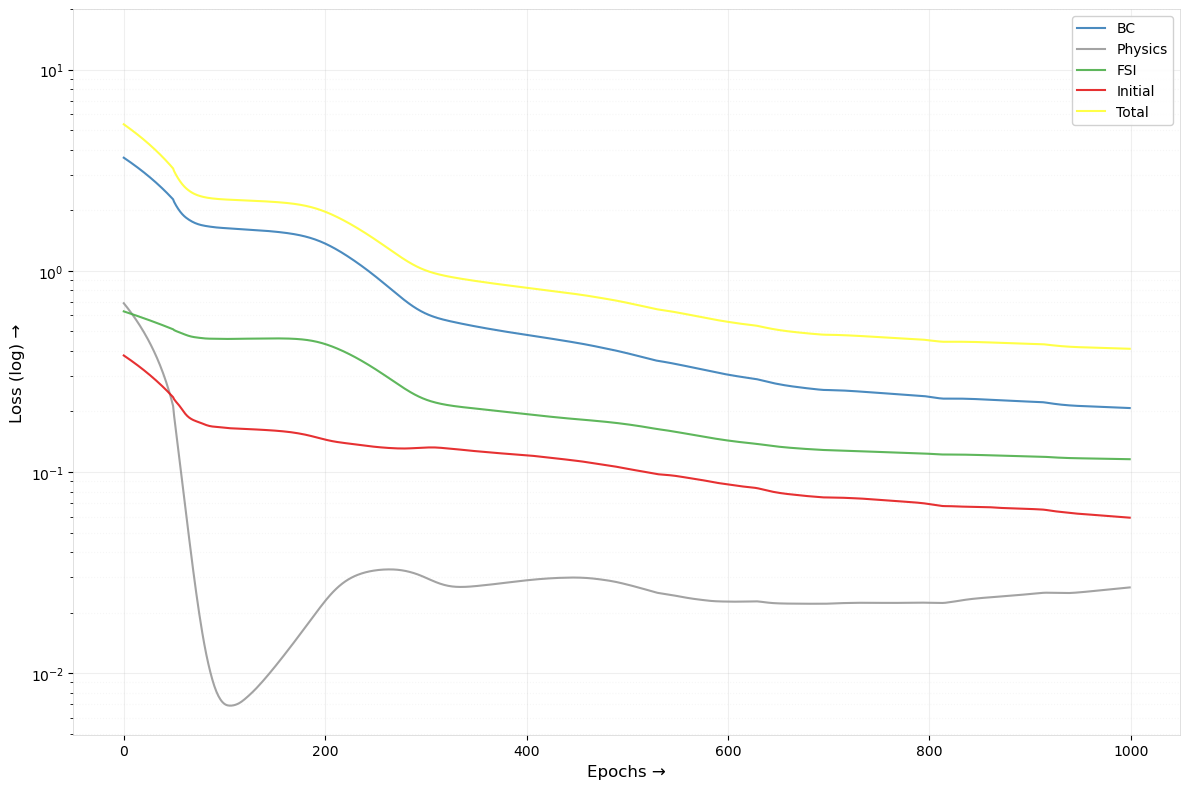

In [10]:
model_path = os.path.join(trainer.logger.get_output_dir(), "model.pth")
model_state = torch.load(model_path)

solver = model_state['solver']

if solver == 'mlp':
    fluid_model = MLP( model_state['fluid_network']).to("cpu")
else:
    fluid_model = KAN( model_state['fluid_network']).to("cpu")


fluid_model.load_state_dict(model_state["fluid_model_state_dict"])

fluid_model.eval()

logger.print(f"Number of parameters: {sum(p.numel() for p in fluid_model.parameters())}")

loss_history = model_state['loss_history']

save_path = os.path.join(logger.get_output_dir(), "loss_history_M1.png")

plot_M1_loss_history(loss_history, save_path, y_max=20, y_min=0, figsize=(12, 8))


In [11]:

animations_reference_dir = os.path.join(logger.get_output_dir(), "animations_reference")


try:
    testing_dataset = load_fluid_testing_dataset(config['dataset_type'])
except Exception as e:
    logger.print(f"Testing dataset not found")
    raise e

skip = 1
time = testing_dataset[: , 0:1][::skip]
x = testing_dataset[: , 1:2][::skip]
y = testing_dataset[: , 2:3][::skip]
u_ref = testing_dataset[: , 3:4][::skip]
v_ref = testing_dataset[: , 4:5][::skip]
p_ref = testing_dataset[: , 5:6][::skip]


In [12]:


with torch.no_grad():
    outputs = fluid_model(torch.cat([time, x, y], dim=1).squeeze(1))

u_pred = outputs[:, 0:1]
v_pred = outputs[:, 1:2]
p_pred = outputs[:, 2:3]


velocity_magnitude_pred= torch.sqrt(u_pred**2 + v_pred**2)

rel_u_l2_error = torch.sqrt(torch.mean((u_pred - u_ref)**2) / torch.mean(u_ref**2))* 100
rel_v_l2_error = torch.sqrt(torch.mean((v_pred - v_ref)**2) / torch.mean(v_ref**2))* 100
rel_p_l2_error = torch.sqrt(torch.mean((p_pred - p_ref)**2) / torch.mean(p_ref**2))* 100

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")



INFO:src.utils.logger:Relative L2 error for u: 4.02e+01 %
INFO:src.utils.logger:Relative L2 error for v: 7.76e+01 %
INFO:src.utils.logger:Relative L2 error for p: 9.06e+01 %


In [26]:
animations_pred_dir = os.path.join(logger.get_output_dir(), "animations_pred")

prediction_df = pd.DataFrame({
    'time': time.detach().numpy().flatten(),
    'x': x.detach().numpy().flatten(),
    'y': y.detach().numpy().flatten(),
    'pressure': p_pred.detach().numpy().flatten(),
    'u_x': u_pred.detach().numpy().flatten(),
    'v_y': v_pred.detach().numpy().flatten(),
    'velocity_magnitude': np.sqrt(u_pred.detach().numpy().flatten()**2 + v_pred.detach().numpy().flatten()**2)
})

create_frames(prediction_df, output_dir=animations_pred_dir, sample_rate=10)


  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.41 (5/11)
  Processing time step 0.51 (6/11)
  Processing time step 0.61 (7/11)
  Processing time step 0.71 (8/11)
  Processing time step 0.81 (9/11)
  Processing time step 0.91 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/pressure
  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.41 (5/11)
  Processing time step 0.51 (6/11)
  Processing time step 0.61 (7/11)
  Processing time step 0.71 (8/11)
  Processing time step 0.81 (9/11)
  Processing time step 0.91 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/velocity_magnitude
  Processing time step 0.00 (1/11)
  Processing time

In [27]:


testing_df = pd.DataFrame({
    'time': time.detach().numpy().flatten(),
    'x': x.detach().numpy().flatten(),
    'y': y.detach().numpy().flatten(),
    'pressure': p_ref.detach().numpy().flatten(),
    'u_x': u_ref.detach().numpy().flatten(),
    'v_y': v_ref.detach().numpy().flatten(),
    'velocity_magnitude': np.sqrt(u_ref.detach().numpy().flatten()**2 + v_ref.detach().numpy().flatten()**2)
})
create_frames(testing_df, output_dir=animations_reference_dir, sample_rate=10)


  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.41 (5/11)
  Processing time step 0.51 (6/11)
  Processing time step 0.61 (7/11)
  Processing time step 0.71 (8/11)
  Processing time step 0.81 (9/11)
  Processing time step 0.91 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/pressure
  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.41 (5/11)
  Processing time step 0.51 (6/11)
  Processing time step 0.61 (7/11)
  Processing time step 0.71 (8/11)
  Processing time step 0.81 (9/11)
  Processing time step 0.91 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/velocity_magnitude
  Processing time step 0.00 (1/11)
  Proce

In [28]:

create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_reference_dir, "pressure"),
        os.path.join(animations_reference_dir, "u_x"),
        os.path.join(animations_reference_dir, "v_y"),
        os.path.join(animations_reference_dir, "velocity_magnitude")
    ],
    output_dir=os.path.join(animations_reference_dir, "gif")
)


Found 11 frames for pressure
Creating animation for pressure...
Saving animation to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/gif/pressure_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/gif/pressure_animation.gif
Found 11 frames for u_x
Creating animation for u_x...
Saving animation to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/gif/u_x_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/gif/u_x_animation.gif
Found 11 frames for v_y
Creating animation for v_y...
Saving animation to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/gif/v_y_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/gif/v_y_animation.gif
No PNG files found in ./checkpoints/2025-04-29_16-02-17-989197/animations_reference/w_z
Found 11 frames for velocity_magnitude
Crea

In [29]:
create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_pred_dir, "pressure"),
        os.path.join(animations_pred_dir, "u_x"),
        os.path.join(animations_pred_dir, "v_y"),
        os.path.join(animations_pred_dir, "velocity_magnitude")
    ],
    output_dir=os.path.join(animations_pred_dir, "gif")
)


Found 11 frames for pressure
Creating animation for pressure...
Saving animation to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/gif/pressure_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/gif/pressure_animation.gif
Found 11 frames for u_x
Creating animation for u_x...
Saving animation to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/gif/u_x_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/gif/u_x_animation.gif
Found 11 frames for v_y
Creating animation for v_y...
Saving animation to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/gif/v_y_animation.gif...
Saving frame 11/11
Animation saved to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/gif/v_y_animation.gif
Found 11 frames for velocity_magnitude
Creating animation for velocity_magnitude...
Saving animation to ./checkpoints/2025-04-29_16-02-17-989197/animations_pred/